# Training SSD (Single Shot MultiBox Detector) on a custom dataset

## Initialization

In [1]:
# Install required libraries
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 926.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.4 MB/s eta 

In [2]:
# Import libraries
import os
import collections

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch_snippets import *

import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
!nvidia-smi # check if GPU is available
%matplotlib inline

Tue Mar  5 05:33:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Clone the sizhky/ssd-utils repository, download dataset and extract it
if not os.path.exists('open-images-bus-trucks'):
    !git clone https://github.com/sizhky/ssd-utils/
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
%cd ssd-utils
from model import SSD300, MultiBoxLoss
from detect import *

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 13.65 KiB | 1.71 MiB/s, done.
/content/ssd-utils


In [5]:
# Get the list of images
root_dir = '../open-images-bus-trucks/'
image_root = f'{root_dir}/images'
dataset_df = pd.read_csv(f'{root_dir}/df.csv')
print(dataset_df.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [6]:
# Create dictionaries with labels and targets
label2target = {label: target + 1 for target, label in enumerate(dataset_df['LabelName'].unique())}
label2target['Background'] = 0
target2label = {target: label for label, target in label2target.items()}
background_class = label2target['Background']
num_classes = len(label2target)

# Print the dictionaries
print("Label to Target:", label2target, "\n")
print("Target to Label:", target2label , "\n")
print("Background Class Index:", background_class, "\n")
print("Number of Classes:", num_classes)

Label to Target:
{'Bus': 1, 'Truck': 2, 'Background': 0}

Target to Label:
{1: 'Bus', 2: 'Truck', 0: 'Background'}

Background Class Index: 0

Number of Classes: 3

In [7]:
# Set up normalization and denormalization transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Create a function to preprocess the image
def preprocess_image(image):
    image = torch.tensor(image).permute(2,0,1)
    image = normalize(image)
    return image.to(device).float()

In [8]:
# Create Dataset class to fetch images and labels
class OpenDataset(Dataset):
    def __init__(self, df, image_dir=image_root):
        self.w, self.h = (300, 300)
        self.image_dir = image_dir
        self.files = Glob(f'{self.image_dir}/*')
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self): return len(self.unique_images)

    def __getitem__(self, idx):
        # Get the image id and path and read the image
        image_id = self.unique_images[idx]
        image_path = find(image_id, self.files)
        image = Image.open(image_path).convert("RGB")
        image = np.array(image.resize((self.w, self.h), resample=Image.BILINEAR))/255.

        # Get the classes
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()

        # Get the bounding boxes and convert to absolute coordinates
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()

        return image, boxes, labels

    def collate_fn(self, batch):
        # Get the images, boxes and labels from the batch and preprocess them
        images, boxes, labels = [], [], []
        for (image, image_boxes, image_labels) in batch:
            image = preprocess_image(image)[None]
            images.append(image)
            boxes.append(torch.tensor(image_boxes).float().to(device)/self.w) # Scale to 0-1
            labels.append(torch.tensor([label2target[label] for label in image_labels]).long().to(device)) # Convert to target
        images = torch.cat(images).to(device)
        return images, boxes, labels

In [9]:
# Get the unique images and split them into train and validation sets
train_ids, val_ids = train_test_split(dataset_df['ImageID'].unique(), test_size=0.1, random_state=4)
train_df, val_df = dataset_df[dataset_df['ImageID'].isin(train_ids)], dataset_df[dataset_df['ImageID'].isin(val_ids)]
print("Number of Train Images:", len(train_df))
print("Number of Validation Images:", len(val_df))

# Create the train and validation datasets
train_ds = OpenDataset(train_df)
val_ds = OpenDataset(val_df)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 4):
    train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)
    return train_dl, val_dl

Number of Train Images: 21628

Number of Validation Images: 2434

In [10]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, boxes, labels = data
    p_boxes, p_labels = model(images)
    loss = criterion(p_boxes, p_labels, boxes, labels)
    loss.backward()
    optimizer.step()
    return loss

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, boxes, labels = data
    p_boxes, p_labels = model(images)
    return criterion(p_boxes, p_labels, boxes, labels) # Return loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.2MB/s]



Loaded base model.



/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


EPOCH: 3.000  val_loss: 1.357  (2270.04s - 0.00s remaining)

100%|██████████| 104/104 [00:00<00:00, 399.42it/s]


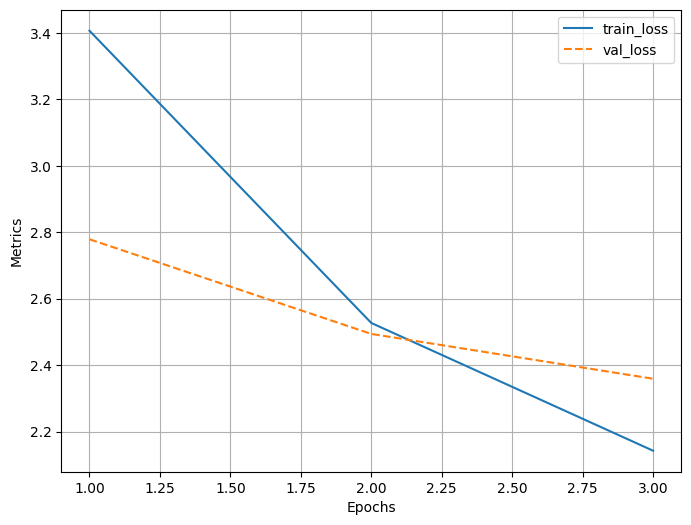

In [11]:
# Train the model
model = SSD300(num_classes, device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
train_dl, val_dl = load_data()
n_epochs = 3
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss.item(), end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss.item(), end='\r')
log.plot_epochs(['train_loss', 'val_loss'])

[[35, 54, 125, 189]]
['Truck @ 0.99']

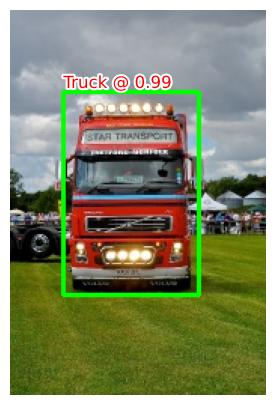

[[44, 52, 204, 139]]
['Truck @ 0.99']

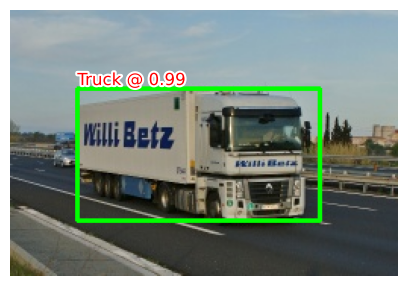

[[0, 0, 256, 192]]
['Background @ 0.00']

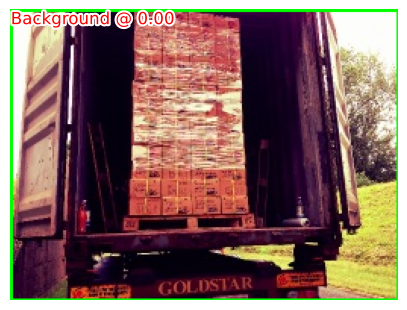

In [13]:
# Choose 3 random images from the validation set and make predictions
for _ in range(3):
    image_id = choose(val_ds.unique_images)
    img_path = find(image_id, val_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5, top_k=200, device=device)
    labels = [target2label[label.item()] for label in labels]
    label_with_conf = [f'{label} @ {score:.2f}' for label, score in zip(labels, scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=12)